In [1]:
ARTICLES_MIN_LENGTH = 300
ARTICLES_PER_AUTHOR = 250
AUTHORS_TO_KEEP = 20

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import sqlalchemy as sqla

con = sqlite3.connect("../../OneMillion/million_post_corpus/corpus.sqlite3", isolation_level=None,
                       detect_types=sqlite3.PARSE_COLNAMES)

df = pd.read_sql_query("SELECT distinct ID_User, COALESCE(Headline, '') || COALESCE(Body, '') as Beitrag from Posts", con)

url = r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()!@:%_\+.~#?&\/\/=]*)"

df = df.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r", url], value=[" "," ", "LINK"], regex=True)

df_minLength = df.loc[df['Beitrag'].apply(len) > ARTICLES_MIN_LENGTH]

In [3]:
## neuer Datensatz ohne User mit weniger als 250 Beiträgen
df_minArticles = df_minLength.groupby('ID_User').filter(lambda x : len(x) >= ARTICLES_PER_AUTHOR)

In [4]:
df_minArticles

,ID_User,Beitrag
592,28526,Im großen war es sehr beeindrucktend. Man kann...
605,28526,Mir bleibt ein sehr junger Mann (etwa so um di...
787,6498,ich habe die 1980er damit verbracht in den Ost...
1121,6247,"Vor etwas mehr vielen vielen Jahren, so gegen ..."
1240,6247,Ein Sternehotel im Montafon.In den späten 80ig...
...,...,...
1009952,29722,"Hier wird etwas getan, was bei Gender auch ger..."
1009996,29722,"Andersdenkende einfach als ""Pigs"" also Schwein..."
1009998,29722,Das ist eine lupenreine Verschwörungstheorie: ...
1010126,29722,"Sie machen jetzt genau das, was ich im unteren..."


In [5]:
## ID_User - Anzahl passende Beiträge
df_minArticles['ID_User'].value_counts()

5854     731
25987    613
22876    595
30344    574
14587    512
26866    473
28816    457
20141    419
24984    417
20349    409
3788     406
18083    401
1795     399
15686    382
18446    375
24667    374
6247     367
19915    366
8765     363
15886    360
10627    352
16722    342
3105     338
6498     336
24758    333
11656    332
27393    331
12471    328
30661    328
29722    318
26532    312
2690     304
1330     300
18940    300
18984    299
21150    299
11582    297
24343    294
12887    289
11910    286
29377    285
8446     285
25582    282
12071    281
12023    275
8323     272
1560     270
7439     266
6169     264
27991    264
16328    259
28526    256
18006    254
28084    251
Name: ID_User, dtype: int64

In [6]:
UserIDListe = df_minArticles.drop_duplicates(subset = ["ID_User"])['ID_User'].tolist()

In [7]:
## AUTHORS_TO_KEEP User aus der Liste - (zufällig sinnvoll? )
import random
IDS = random.sample(UserIDListe, AUTHORS_TO_KEEP)
print(IDS)

[3788, 2690, 11910, 18446, 29377, 6247, 15686, 21150, 15886, 11582, 28816, 3105, 25987, 24343, 16722, 29722, 24667, 6498, 27991, 12071]


In [8]:
df_nArticlesPerUser = pd.DataFrame({"ID_User": [], 'Beitrag': []})
df_nArticlesPerUser['ID_User'] = df_nArticlesPerUser['ID_User'].astype(int)

for userID in IDS:
    df_nArticlesPerUser = pd.concat([df_nArticlesPerUser, df_minArticles.query("ID_User == @userID")[['ID_User','Beitrag']].sample(n = 250, replace = False)])
    
df_nArticlesPerUser = df_nArticlesPerUser.reset_index(drop=True)

In [9]:
df_nArticlesPerUser

,ID_User,Beitrag
0,3788,"Nein, in Tunesien, Sie Schlaumeier...denn der ..."
1,3788,Selten so einen Mumpitz gelesen. Außer ein bis...
2,3788,"Also...wie oben beschrieben, wird sich Israel ..."
3,3788,Sie haben da eben einige Details ausgelassen.....
4,3788,"Genau! Lauter ""Behauptungen"" anonymer Zeugen, ..."
...,...,...
4995,12071,"Hier geht es nur ums Greek-bashing, die arroga..."
4996,12071,"Und unsere Spitäler erbaut der Hielige Geist, ..."
4997,12071,"Wenn hier Behauptungen aufgestellt werden, die..."
4998,12071,"Diese rückständigen Despoten, sind die Kriegsh..."


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=15)
features = tfidf.fit_transform(df_nArticlesPerUser.Beitrag).toarray()
labels = df_nArticlesPerUser.ID_User
features.shape

(5000, 2267)

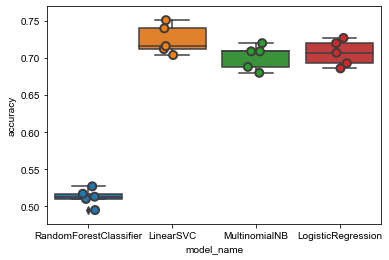

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import seaborn as sns

models = [
RandomForestClassifier(n_estimators=100),
LinearSVC(),
MultinomialNB(),
LogisticRegression(),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy',cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
sns.set(rc={"figure.figsize":(3, 4)})
plt.show()

In [12]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.7246
LogisticRegression        0.7066
MultinomialNB             0.7012
RandomForestClassifier    0.5124
Name: accuracy, dtype: float64

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Model mit höchster Accuracy: LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
model = LinearSVC()
X_train, X_test, y_train, y_test =train_test_split(features, labels, test_size=0.2, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)

#disp = ConfusionMatrixDisplay(matrix, display_labels=IDS[0:AUTHORS_TO_KEEP])
#fig, ax = plt.subplots(figsize=(10,10))
#disp.plot(ax=ax)
#plt.show()

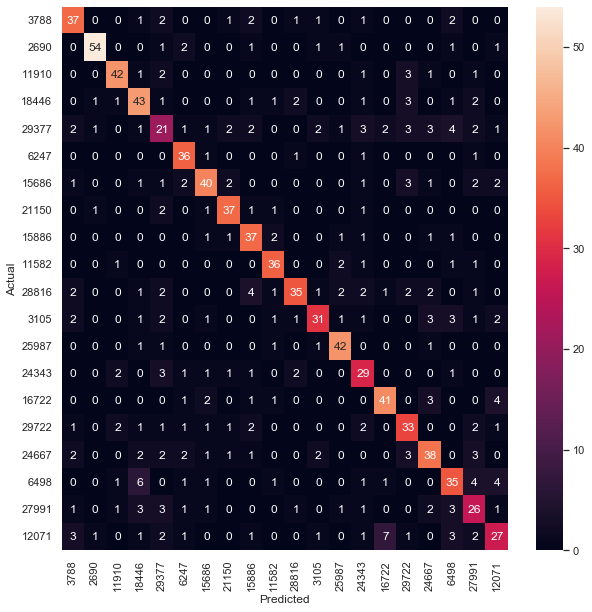

In [45]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(matrix, annot=True, fmt='d', xticklabels=IDS[0:AUTHORS_TO_KEEP], yticklabels=IDS[0:AUTHORS_TO_KEEP])
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()